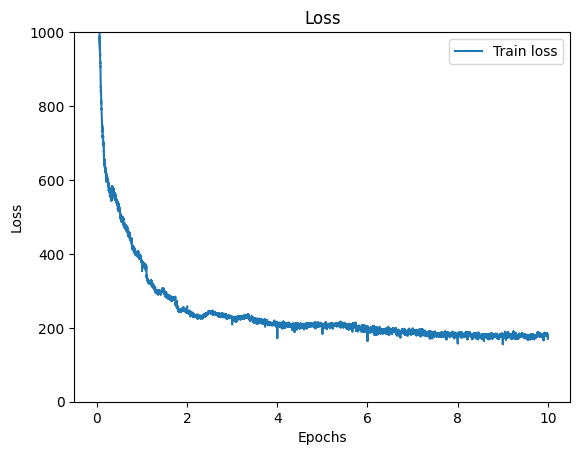

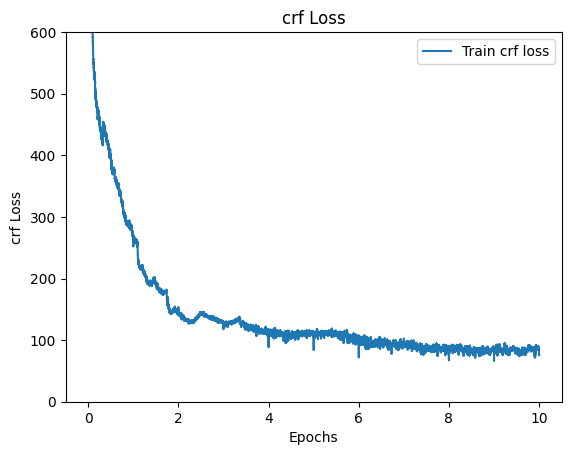

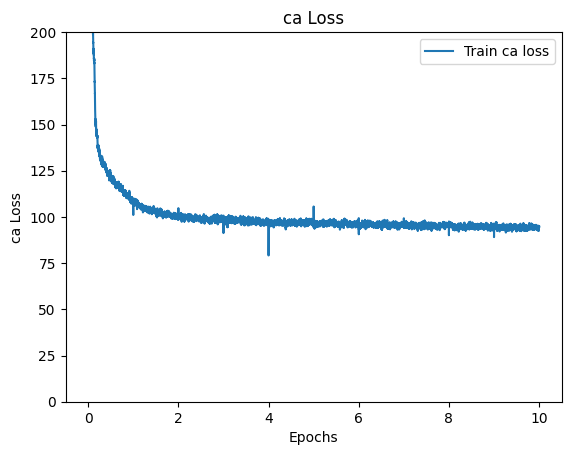

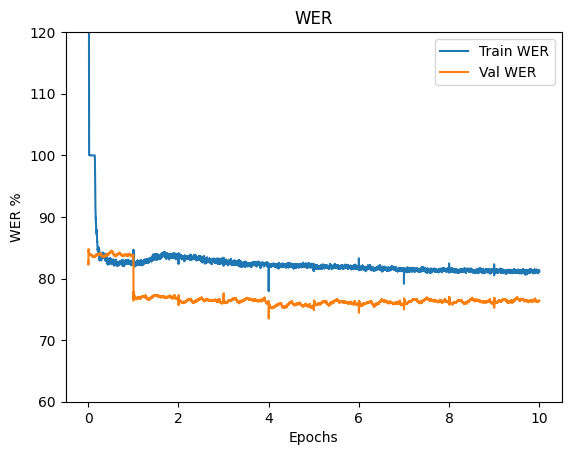

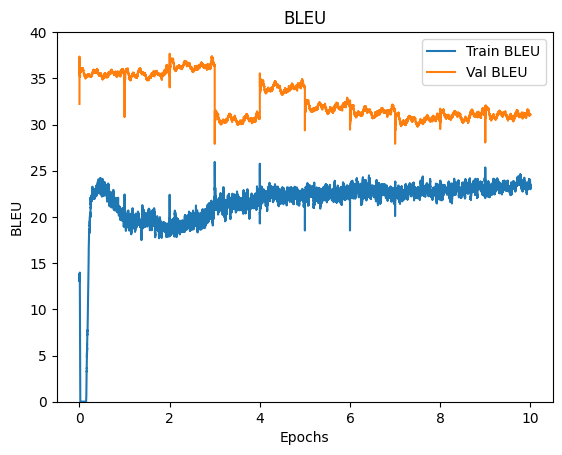

In [34]:
import matplotlib.pyplot as plt
import numpy as np

data1 = '20251112_013826'

with open('./model/MyOriginal_train_loss_' + data1 + '.csv',encoding='utf-8')as f:
    line1_all = f.readlines()

with open('./model/MyOriginal_val_loss_' + data1 + '.csv',encoding='utf-8')as f:
    line2_all = f.readlines()


i = 0
x = []
loss = []
ctc = []
kd = []
error = []
bleu = []
v_i = 0
v_x = []
v_loss = []
v_ctc = []
v_kd = []
v_error = []
v_bleu = []

#line2 = line2_all[0].replace( "\n", "")
#len_tr_loader = int(line2)

for i, line1 in enumerate( line1_all ):
    if i == 0:
        line1 = line1.replace( "\n", "")
        len_tr_loader = int(line1)
    else:
        line1_split = line1.split(",")
        i += 1
        x.append( i / len_tr_loader )
        loss.append( float(line1_split[1].split(' ')[1]) )
        ctc.append( float(line1_split[2].split(' ')[1]) )
        kd.append( float(line1_split[3].split(' ')[1]) )
        error.append( float(line1_split[4].split(' ')[1]) )
        bleu.append( float(line1_split[5].split( ' ' )[1]))

#print( "pad:", pad )

for i, line2 in enumerate( line2_all ):
    if i == 0:
        line2 = line2.replace( "\n", "")
        len_val_loader = int(line2)
    else:
        #print( "line2:", line2 )
        line2_split = line2.split(",")
        v_i += 1
        v_x.append( v_i / len_val_loader )
        #v_loss.append( float(line2_split[1].split(' ')[1]) )
        #v_ctc.append( float(line2_split[2].split(' ')[1]) )
        #v_kd.append( float(line2_split[3].split(' ')[1]) )
        v_error.append( float(line2_split[1].split(' ')[1] ) )
        v_bleu.append( float(line2_split[2].split( ' ' )[1]))

plt.plot( x, loss, label="Train loss")
#plt.plot( v_x, v_loss, label="Val Loss" )
plt.title( "Loss")
plt.xlabel( 'Epochs')
plt.ylabel( 'Loss')
plt.legend()
plt.ylim( 0, 1000 )
plt.show()

plt.plot( x, ctc, label="Train crf loss")
#plt.plot( v_x, v_ctc, label="Val crf Loss" )
plt.title( "crf Loss")
plt.xlabel( 'Epochs')
plt.ylabel( 'crf Loss')
plt.legend()
plt.ylim( 0, 600 )
plt.show()

plt.plot( x, kd, label="Train ca loss")
#plt.plot( v_x, v_kd, label="Val ca Loss" )
plt.title( "ca Loss")
plt.xlabel( 'Epochs')
plt.ylabel( 'ca Loss')
plt.legend()
plt.ylim( 0, 200 )
plt.show()

plt.plot( x, error, label = 'Train WER')
plt.plot( v_x, v_error, label="Val WER")
plt.title( "WER")
plt.xlabel( 'Epochs')
plt.ylabel( 'WER %')
plt.legend()
plt.ylim( 60, 120)
plt.show()

plt.plot( x, bleu, label = 'Train BLEU')
plt.plot( v_x, v_bleu, label="Val BLEU")
plt.title( "BLEU")
plt.xlabel( 'Epochs')
plt.ylabel( 'BLEU')
plt.legend()
plt.ylim( 0, 40 )
plt.show()




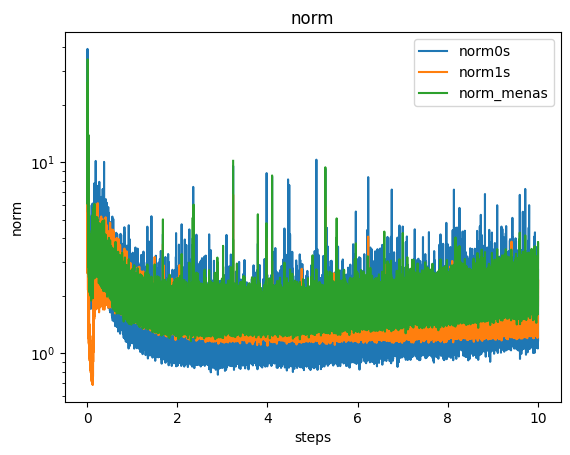

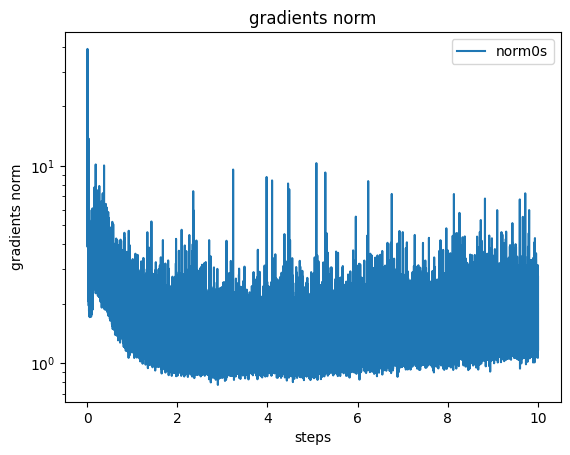

In [36]:
with open("./model/norm_" + data1 + ".csv",encoding='utf-8')as f:
    line_all = f.readlines()

epochs = []
steps = []
norm0s = []
norm1s = []
norm_means = []

for i, line in enumerate( line_all ):
    line_split = line.split( ", " )
    steps.append( float( line_split[1].split(": ")[1] ) )
    epochs.append( float( line_split[1].split(": ")[1] ) / len_tr_loader )
    norm0s.append( float( line_split[2].split(": ")[1] ) )
    norm1s.append( float( line_split[3].split(": ")[1] ) )
    norm_means.append( float( line_split[4].split(": ")[1] ) )

#plt.plot( steps, norm0s, label = 'norm0s')
#plt.plot( steps, norm1s, label = 'norm1s')
#plt.plot( steps, norm_means, label = 'norm_menas')
plt.plot( epochs, norm0s, label = 'norm0s')
plt.plot( epochs, norm1s, label = 'norm1s')
plt.plot( epochs, norm_means, label = 'norm_menas')
plt.title( "norm")
plt.xlabel( 'steps')
plt.ylabel( 'norm')
plt.yscale( 'log' )
plt.legend()
#plt.ylim( 0, 2 )
plt.show()

#plt.plot( steps, norm0s, label = 'norm0s')
plt.plot( epochs, norm0s, label = 'norm0s')
plt.title( "gradients norm")
plt.xlabel( 'steps')
plt.ylabel( 'gradients norm')
plt.yscale( 'log' )
plt.legend()
#plt.ylim( 0, 1.0 )
plt.show()

In [82]:
def calc_loss_ca( logits, captions, c ):

    eps = 1e-4

    B, T, V = logits.size()
    
    one_hot_cap = F.one_hot( captions, num_classes = len( tokenizer ) ) # B * T * V

    lcabi = torch.zeros( (B, T),  dtype=torch.float, device = logits.device )
    zeroB = torch.zeros( (B),  dtype=torch.float, device = logits.device )
    for i in range( T ):
        tmp = torch.stack( [ torch.log( (  1.0 - torch.exp( torch.sum( logits[:,i,:] * one_hot_cap[:,j,:], dim = 1 ) ) / \
            ( torch.sum( torch.exp(logits[:,i]), dim = 1 ) + eps ) + eps ) ) if j != i  else zeroB \
            for j in range( max( 0, i - c ), min(  T, i + c ) ) ], dim = 0 )  # window 幅 * B
        lcabi[:,i] = torch.sum( tmp, dim = 0 ) # wubdiow 幅 * B を window 幅について sum
    
    # lcabi は B * T
    
    pbi = torch.exp( torch.sum( logits * one_hot_cap, dim = 2 ) ) / ( torch.sum( torch.exp( logits ), dim = 2 ) + eps ) # B * T
    logpbi = torch.log( pbi ) # B * T
    #print( "logpbi:", torch.mean( torch.mean( logpbi )))
    #logpbi = torch.sum( logits * one_hot_cap, dim = 2 ) - torch.log( torch.sum( torch.exp(logits), dim = 2 ) + eps )
    #print( "logpbi:", torch.mean( torch.mean(logpbi)) )
    
    loss_ca = -torch.mean( torch.mean( logpbi + lcabi, dim = 1 ), dim = 0 )
    
    return loss_ca

In [83]:
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel, CLIPVisionModel, BertForPreTraining

model_id = "google-bert/bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained( model_id )
sos_token_id = tokenizer.encode( [ "[unused0]" ] )[1]
eos_token_id = tokenizer.encode( [ "[unused1]" ] )[1]


#logits = torch.randn( ( 4, 97, 30522 ) )
#captions = torch.randint( 0, len( tokenizer ), size=( 4,97 ) )

c = 3

loss_ca = calc_loss_ca( logits, captions, c )

print( loss_ca )

tensor(10.8654)


In [100]:
def calc_loss_ca( logits, captions, c ):

    B, T, V = logits.size()
    
    one_hot_cap = F.one_hot( captions, num_classes = len( tokenizer ) ) # B * T * V

    P = torch.exp( torch.sum( logits * one_hot_cap, dim = 2 ) ) / torch.sum( torch.exp( logits ), dim = 2 ) # B * T
    loss1 = - torch.sum( torch.sum( torch.log( P ), dim = 1 ) , dim = 0 )

    Pca = [ torch.stack( [ torch.exp( torch.sum( logits[:,i,:] * one_hot_cap[:,j,:], dim = 1 ) ) / torch.sum( torch.exp(logits[:,i]), dim = 1 ) \
          for j  in range( T )] , dim = 0 ) for i in range( T ) ]

    Pca = torch.stack( Pca, dim = 0 )
    Pca = Pca.permute( 2, 1, 0 )

    lca = torch.zeros( ( B ), dtype=torch.float, device = logits.device )
    zeroB = torch.zeros( (B),  dtype=torch.float, device = logits.device )
    for index in range( T ):
        tmp = torch.stack( [ torch.log( 1.0 - Pca[:, index, index2 ] ) if index2 != index else zeroB  \
            for index2 in range( max( 0, index - c ), min(  T, index + c ) ) ], dim = 0 )
        tmp = tmp.transpose( 0, 1 )
        lca[:] += torch.sum( tmp[:], dim = 1 )

    lca = - torch.sum( lca , dim = 0 ) * 10000
    
    print( "loss1:", loss1 )
    print( "lca:", lca )

    loss_ca = loss1 + lca
    
    return loss_ca

In [101]:
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel, CLIPVisionModel, BertForPreTraining

model_id = "google-bert/bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained( model_id )
sos_token_id = tokenizer.encode( [ "[unused0]" ] )[1]
eos_token_id = tokenizer.encode( [ "[unused1]" ] )[1]


logits = torch.randn( ( 4, 97, 30522 ) )
captions = torch.randint( 0, len( tokenizer ), size=( 4,97 ) )

B, T, V = logits.size()
c = 3

loss_ca = calc_loss_ca( logits, captions, c )

print( loss_ca )

loss1: tensor(4165.9678)
lca: tensor(640.9407)
tensor(4806.9087)


In [98]:
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel, CLIPVisionModel, BertForPreTraining

model_id = "google-bert/bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained( model_id )
sos_token_id = tokenizer.encode( [ "[unused0]" ] )[1]
eos_token_id = tokenizer.encode( [ "[unused1]" ] )[1]

print( "sos_tokeni_d:", sos_token_id )
print( "eos_token_id:", eos_token_id )

logits = torch.randn( ( 4, 97, 30522 ) )
captions = torch.randint( 0, len( tokenizer ), size=( 4,97 ) )

B, T, V = logits.size()
c = 3

one_hot_cap = F.one_hot( captions, num_classes = len( tokenizer ) ) # B * T * V

#loss_ca = calc_loss_ca( logits, captions, 3 )

Pca = [ torch.stack( [ torch.exp( torch.sum( logits[:,i,:] * one_hot_cap[:,j,:], dim = 1 ) ) / torch.sum( torch.exp(logits[:,i]), dim = 1 ) \
          for j  in range( T )] , dim = 0 ) for i in range( T ) ]

Pca = torch.stack( Pca, dim = 0 )
#Pca = torch.stack( PCa, dim = 1 )

Pca = Pca.permute( 2, 1, 0 )
print( Pca.size() )


lca = torch.zeros( ( B ), dtype=torch.float, device = logits.device )
#sum1 = torch.zeros( ( B ), dtype=torch.float, device = logits.device )
zeroB = torch.zeros( (B),  dtype=torch.float, device = logits.device )
for index in range( T ):
    tmp = torch.stack( [ torch.log( 1.0 - Pca[:, index, index2 ] ) if index2 != index else zeroB  \
        for index2 in range( max( 0, index - c ), min(  T, index + c ) ) ], dim = 0 )
    tmp = tmp.transpose( 0, 1 )
    #sum1[:] = torch.sum( tmp[:], dim = 1 )
    #lca[:] += sum1[:]
    lca[:] += torch.sum( tmp[:], dim = 1 )

#print( lca.size() )   
#lca = torch.mean( lca, dim = 0 ) / logits.size(1)
#lca = - torch.sum( lca, dim = 0 ) * 10000
lca = - torch.sum( lca , dim = 0 ) * 10000

print( lca )

sos_tokeni_d: 1
eos_token_id: 2
torch.Size([4, 97, 97])
tensor(637.7205)


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel, CLIPVisionModel, BertForPreTraining

model_id = "google-bert/bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained( model_id )
sos_token_id = tokenizer.encode( [ "[unused0]" ] )[1]
eos_token_id = tokenizer.encode( [ "[unused1]" ] )[1]

print( "sos_tokeni_d:", sos_token_id )
print( "eos_token_id:", eos_token_id )

log_softmax = nn.LogSoftmax( dim = 2 )
#softmax = nn.Softmax( dim = 2 )
criterion_nll = nn.NLLLoss( reduction = 'none' )

log_probs = log_softmax( torch.randn( ( 4, 97, 30522 ) ) )
captions = torch.randint( 0, len( tokenizer ), size=( 4,97 ) )

def calc_loss_nll( train_log_prob_matrix, train_batch_tgt ):
    bsz, tgt_len = train_batch_tgt.size()
    
    train_log_prob_matrix_unbind = torch.unbind(train_log_prob_matrix, dim = 0)
    assert len(train_log_prob_matrix_unbind) == tgt_len
    train_truth_tgt_unbind = torch.unbind(train_batch_tgt, dim = 1)
    assert len(train_truth_tgt_unbind) == tgt_len

    nll_loss_list = []

    for index in range(tgt_len):
        curr_step_log_prob = train_log_prob_matrix_unbind[index]
        curr_step_tgt = train_truth_tgt_unbind[index].view(bsz)
        one_nll_loss = criterion_nll(curr_step_log_prob, curr_step_tgt)
        #print( "one_nll_loss size:", one_nll_loss.size() )
        assert one_nll_loss.size() == torch.Size([bsz])
        nll_loss_list.append(one_nll_loss)

    nll_loss_matrix = torch.stack(nll_loss_list, dim = 1)
    #print( "nll_loss_matrix size:", nll_loss_matrix.size() )
    
    train_nll_loss = nll_loss_matrix.sum(-1)
    #assert train_batch_crf_loss.size() == train_nll_loss.size()

    return train_nll_loss

def calc_loss_nll2( train_log_prob_matrix, train_batch_tgt ):
    bsz, tgt_len = train_batch_tgt.size()
    
    train_log_prob_matrix_unbind = torch.unbind(train_log_prob_matrix, dim = 0)
    assert len(train_log_prob_matrix_unbind) == tgt_len
    train_truth_tgt_unbind = torch.unbind(train_batch_tgt, dim = 1)
    assert len(train_truth_tgt_unbind) == tgt_len

    nll_loss_list = []

    for index in range(tgt_len):
        curr_step_log_prob = train_log_prob_matrix_unbind[index]
        curr_step_tgt = train_truth_tgt_unbind[index].view(bsz)
        one_nll_loss = criterion_nll(curr_step_log_prob, curr_step_tgt)
        assert one_nll_loss.size() == torch.Size([bsz])
        nll_loss_list.append(one_nll_loss)

    nll_loss_matrix = torch.stack(nll_loss_list, dim = 1)

    train_nll_loss = nll_loss_matrix.sum(-1)
    #assert train_batch_crf_loss.size() == train_nll_loss.size()

    return train_nll_loss


nll_loss = calc_loss_nll( log_probs.transpose(0,1), captions )
print( torch.mean(nll_loss) )


print( captions.view(-1).size() )
for index in range( log_probs.size(1) ):
    nll_loss2 = criterion_nll( log_probs[:,index], captions[:,index] )
    #print( nll_loss2 )

nll_loss3 = criterion_nll( log_probs.view( log_probs.size(0) * log_probs.size(1), -1 ), captions.view( -1 ) )
print( torch.sum( nll_loss3 ) / log_probs.size(0) )


    

sos_tokeni_d: 1
eos_token_id: 2
tensor(1044.8959)
torch.Size([388])
tensor(1044.8958)
